In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm


#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

In [71]:
'''# Generate a random variable from a Beta(alpha, beta_param) distribution on [a, b]
def rng_beta(alpha, beta_param, a, b):
    x = np.random.beta(alpha, beta_param)  
    y = a + (b - a) * x
    return y
    
# PDF of a Beta distribution on interval [a, b]
def beta_pdf_on_interval(x, alpha, beta_param, a, b):
    """
    Compute the PDF of a Beta(alpha, beta_param) distribution on [a, b] at x.
    """
    # Transform x to [0, 1]
    y = (x - a) / (b - a)
    pdf = beta.pdf(y, alpha, beta_param) / (b - a)
    # Set pdf to 0 outside [a, b]
    pdf = np.where((x >= a) & (x <= b), pdf, 0)
    return pdf'''

'# Generate a random variable from a Beta(alpha, beta_param) distribution on [a, b]\ndef rng_beta(alpha, beta_param, a, b):\n    x = np.random.beta(alpha, beta_param)  \n    y = a + (b - a) * x\n    return y\n    \n# PDF of a Beta distribution on interval [a, b]\ndef beta_pdf_on_interval(x, alpha, beta_param, a, b):\n    """\n    Compute the PDF of a Beta(alpha, beta_param) distribution on [a, b] at x.\n    """\n    # Transform x to [0, 1]\n    y = (x - a) / (b - a)\n    pdf = beta.pdf(y, alpha, beta_param) / (b - a)\n    # Set pdf to 0 outside [a, b]\n    pdf = np.where((x >= a) & (x <= b), pdf, 0)\n    return pdf'

In [72]:
#==========================Gaussian Target Distribution==========================
def target_pdf(x, mu=0, sigma=1):
    """
    Compute the PDF of a Gaussian distribution with mean 0 and standard deviation 1.
    """
    return norm.pdf(x, mu, sigma)



In [73]:
#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [74]:
#Initializing the random number generator
# Use the defined rng for generating samples
def importance_integration(f, N):
    
    # Generate N samples from the target distribution (standard normal) using rng
    x_samples = rng.normal(0, 1, N)

    # Compute the importance weights
    weights = f(x_samples) / target_pdf(x_samples)  # PDF of the target distribution
    estimate = np.mean(weights)  # Mean of the weights as the estimator of the integral

    #Find estimator of Variance of the weights
    variance_weights = np.var(weights)/N

    standard_error = np.sqrt(variance_weights) / np.sqrt(N)
    
    return estimate, variance_weights, standard_error

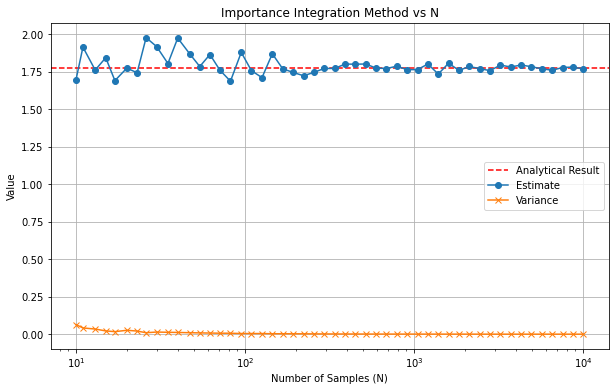

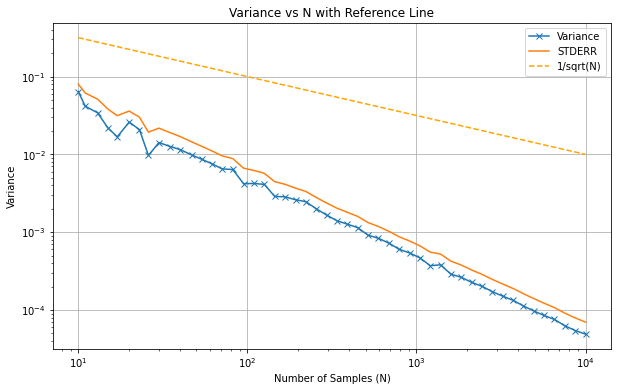

In [75]:
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)




# Define a range of N values
N_values = np.logspace(1, 4, num=50, dtype=int)  # N ranges from 10 to 10,000

# Initialize lists to store results
estimates = []
variances = []
standard_errors = []

# Compute the importance integration for each N
for N in N_values:
    estimate, variance, standard_error = importance_integration(f, N)
    estimates.append(estimate)
    variances.append(variance)
    standard_errors.append(standard_error)


# Plot the results
plt.figure(figsize=(10, 6))
# Analytical result for the integral of f(x) = e^(-x^2) over the real line
analytical_result = np.sqrt(np.pi)

# Add the analytical result as a horizontal line
plt.axhline(y=analytical_result, color='red', linestyle='--', label='Analytical Result')
plt.plot(N_values, estimates, label='Estimate', marker='o')
plt.plot(N_values, variances, label='Variance', marker='x')
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Value')
plt.title('Importance Integration Method vs N')
plt.legend()
plt.grid(True)
plt.show()

# Compute the reference line 1/sqrt(N_values)
reference_line = 1 / np.sqrt(N_values)

# Plot the variance and reference line
plt.figure(figsize=(10, 6))
plt.plot(N_values, variances, label='Variance', marker='x')
plt.plot(N_values, standard_errors, label='STDERR')
plt.plot(N_values, reference_line, label='1/sqrt(N)', linestyle='--', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Variance')
plt.title('Variance vs N with Reference Line')
plt.legend()
plt.grid(True)
plt.show()